In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/rishank-shah/Diabetes-Prediction/main/diabetes.csv')

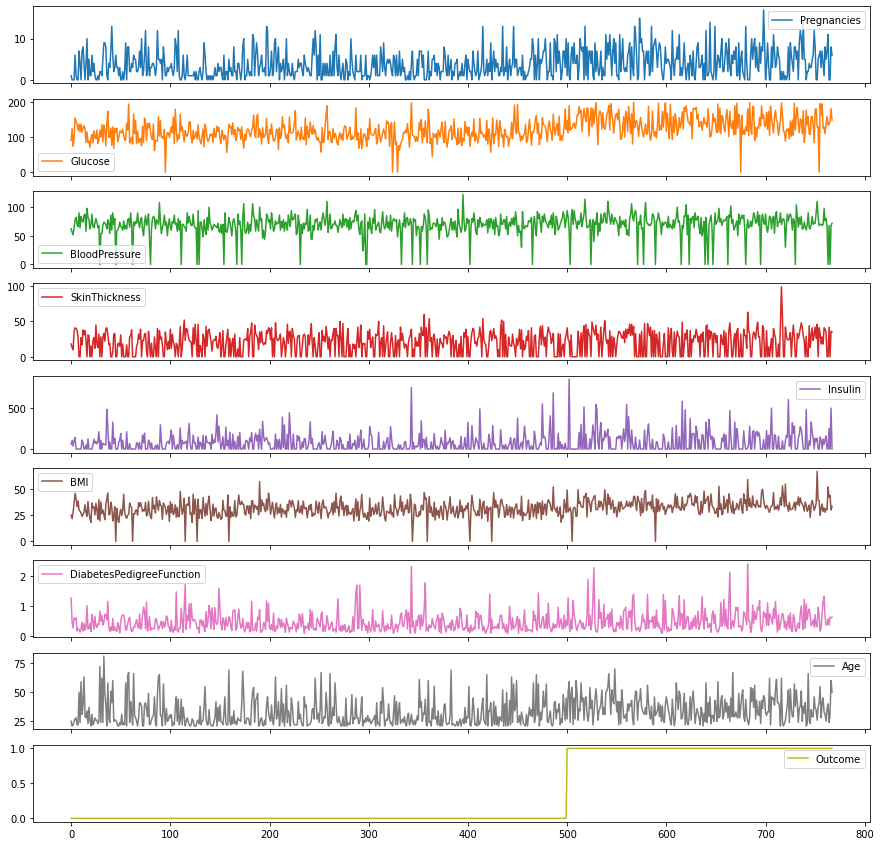

In [3]:
df.sort_values(by=["Outcome"],inplace=True,ignore_index=True)
df.plot(figsize = (15,15), subplots = True)
plt.show()

<Axes: xlabel='Outcome', ylabel='count'>

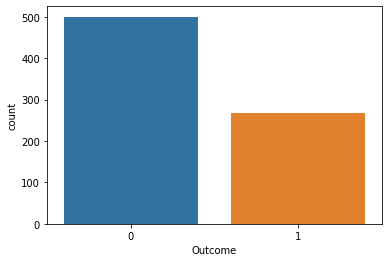

In [4]:
sns.countplot(x = 'Outcome',data = df)

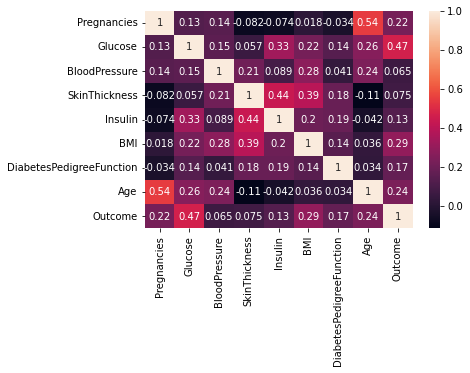

In [5]:
sns.heatmap(df.corr(), annot=True)
plt.show()

In [6]:
df["Glucose"].fillna(df["Glucose"].mean(), inplace = True)
df["BloodPressure"].fillna(df["BloodPressure"].mean(), inplace = True)
df["SkinThickness"].fillna(df["SkinThickness"].mean(), inplace = True)
df["Insulin"].fillna(df["Insulin"].mean(), inplace = True)
df["BMI"].fillna(df["BMI"].mean(), inplace = True)

In [7]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,90,62,18,59,25.1,1.268,25,0
1,0,124,56,13,105,21.8,0.452,21,0
2,0,74,52,10,36,27.8,0.269,22,0
3,0,97,64,36,100,36.8,0.600,25,0
4,6,154,78,41,140,46.1,0.571,27,0
...,...,...,...,...,...,...,...,...,...
763,11,135,0,0,0,52.3,0.578,40,1
764,0,135,68,42,250,42.3,0.365,24,1
765,0,145,0,0,0,44.2,0.630,31,1
766,8,181,68,36,495,30.1,0.615,60,1


In [8]:
continuous_variables = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                        "BMI", "DiabetesPedigreeFunction", "Age"]
for attr in continuous_variables:
    Q1 = df[attr].quantile(0.25)
    Q3 = df[attr].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    df = df[(df[attr]>lower_limit)&(df[attr]<upper_limit)]

In [9]:
df_majority = df[(df["Outcome"]==0)]
df_minority = df[(df["Outcome"]==1)]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=500,random_state=42)
df = pd.concat([df_minority_upsampled,df_majority])
df["Outcome"].value_counts()

1    500
0    438
Name: Outcome, dtype: int64

In [10]:
scaler = MinMaxScaler()
scaler.fit_transform(df)

array([[0.92307692, 0.62337662, 0.64705882, ..., 0.41512915, 0.84090909,
        1.        ],
       [0.15384615, 0.58441558, 0.47058824, ..., 0.42804428, 0.04545455,
        1.        ],
       [0.07692308, 0.88961039, 0.38235294, ..., 0.23062731, 0.38636364,
        1.        ],
       ...,
       [0.53846154, 0.57792208, 0.67647059, ..., 0.5701107 , 0.36363636,
        0.        ],
       [0.23076923, 0.88311688, 0.38235294, ..., 0.17804428, 0.11363636,
        0.        ],
       [0.76923077, 0.50649351, 0.58823529, ..., 0.400369  , 0.54545455,
        0.        ]])

In [11]:
X=df.drop('Outcome',axis='columns')
# X = df.iloc[:, [1, 3, 4, 5, 7]].values
Y=df["Outcome"]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20, random_state = 0 )
print("train data length:",len(X_train))
print("test data length:",len(X_test))

train data length: 750
test data length: 188


In [12]:
model = RandomForestClassifier(n_estimators= 100, random_state=0)
model.fit(X_train,Y_train)

with open('rf_model', 'wb') as f:
    pickle.dump(model, f)

Y_pred_random_forest = model.predict(X_test)
print("Train Score:",model.score(X_train,Y_train))
print("Test Score:",model.score(X_test,Y_test))

print('f1_score',f1_score(Y_test, Y_pred_random_forest))
print('precision_score',precision_score(Y_test, Y_pred_random_forest))
print('recall_score',recall_score(Y_test, Y_pred_random_forest))
print('roc_auc_score',roc_auc_score(Y_test, Y_pred_random_forest))

Train Score: 1.0
Test Score: 0.9042553191489362
f1_score 0.91
precision_score 0.875
recall_score 0.9479166666666666
roc_auc_score 0.9033061594202898


0.9042553191489362


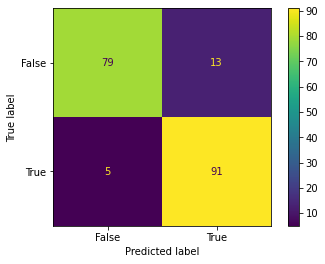

In [13]:
y_pred_rf = model.predict(X_test)
confusion = confusion_matrix(Y_test, y_pred_rf)
tn, fp, fn, tp = confusion.ravel()
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])
accuracy = (tp + tn) / (tp + fp + fn + tn)
print(accuracy)

cm_display.plot()
plt.show()

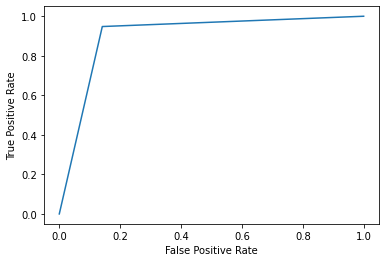

In [14]:
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_rf)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

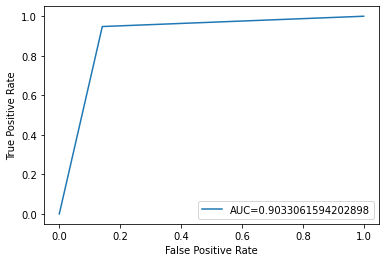

In [15]:
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_rf)
auc = metrics.roc_auc_score(Y_test, y_pred_rf)

#create AUC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [16]:
ada_boost = AdaBoostClassifier(n_estimators= 100, random_state=0)
ada_boost.fit(X_train, Y_train)
Y_pred_ada = ada_boost.predict(X_test)
print("Train Score ada :",ada_boost.score(X_train,Y_train))
print("Test Score ada :",ada_boost.score(X_test,Y_test))
print('f1_score ada',f1_score(Y_test, Y_pred_ada))
print('precision_score ada',precision_score(Y_test, Y_pred_ada))
print('recall_score ada',recall_score(Y_test, Y_pred_ada))
print('roc_auc_score ada',roc_auc_score(Y_test, Y_pred_ada))

print("\n")

decision = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
decision.fit(X_train, Y_train)
Y_pred_dt = decision.predict(X_test)
print("Train Score dt:",decision.score(X_train,Y_train))
print("Test Score dt:",decision.score(X_test,Y_test))
print('f1_score dt',f1_score(Y_test, Y_pred_dt))
print('precision_score dt',precision_score(Y_test, Y_pred_dt))
print('recall_score dt',recall_score(Y_test, Y_pred_dt))
print('roc_auc_score dt',roc_auc_score(Y_test, Y_pred_dt))

Train Score ada : 0.8906666666666667
Test Score ada : 0.824468085106383
f1_score ada 0.8374384236453202
precision_score ada 0.794392523364486
recall_score ada 0.8854166666666666
roc_auc_score ada 0.8231431159420289


Train Score dt: 1.0
Test Score dt: 0.851063829787234
f1_score dt 0.8679245283018867
precision_score dt 0.7931034482758621
recall_score dt 0.9583333333333334
roc_auc_score dt 0.8487318840579711


In [17]:
voting_classifier = VotingClassifier(
    estimators = [('ADA',AdaBoostClassifier(n_estimators= 100, random_state=0)), ('RF', RandomForestClassifier(n_estimators= 100, random_state=0)), 
                  ('DT', DecisionTreeClassifier(criterion = 'entropy', random_state = 0))], 
    voting='hard')

voting_classifier.fit(X_train, Y_train)
y_pred_vch = voting_classifier.predict(X_test)
print(accuracy_score(Y_test, y_pred_vch))

0.8882978723404256


In [18]:
def _get_model_name(model):
    if isinstance(model, Pipeline):
        estimator = model.steps[-1][1]
        name = "Pipeline_" + str(estimator)[:str(estimator).find("(")]
    else: 
        name = str(model)[:str(model).find("(")]
    return name
    
    
def plot_cv_score(X, y, models_list, cv = 5, scoring_list = None, refit = True, return_scores = False):
    names, mean_score = list(), list()
    ldf = list()
    mnames = list()
    
    for i, model in enumerate(models_list):
        name = _get_model_name(model)
        if name == "RandomForestClassifier":
          name = "RF"
        elif name == "DecisionTreeClassifier":
          name = "DT"
        elif name == "AdaBoostClassifier":
          name = "AB"
    
        if refit:
            model.fit(X, y)
                
        for metric in score_list:
            
            score = cross_val_score(model, X, y, cv = cv, scoring = metric, n_jobs= -1)
            mean_score.append(np.mean(score * 100))
    
    
        tmp = pd.DataFrame({name: mean_score}, index = score_list)
        
            
            
        ldf.append(tmp)
        
        
        mean_score = list()
        
    frame_scores = reduce(lambda x,y: pd.merge(x,y, left_index = True, right_index = True), ldf).T
        
    fig, ax  = plt.subplots(1,1, figsize = (9,8))
    frame_scores.plot.bar(ax = ax, cmap = 'RdYlBu', edgecolor = "black")
    ax.legend(loc = 'center right')
    ax.set_xlabel("Score")
    ax.tick_params('x', labelrotation=0) 
    ax.set_title("Cross validation model benchmark")

    if return_scores:    
        return frame_scores

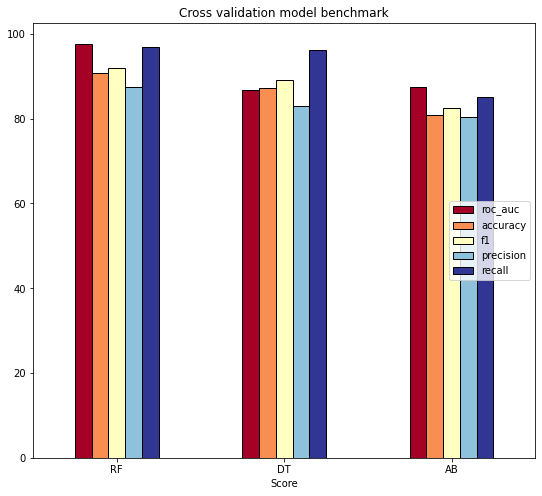

In [19]:
models_list =[RandomForestClassifier(n_estimators= 100, random_state=0),
              DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
              AdaBoostClassifier(n_estimators= 100, random_state=0)]

score_list = ["roc_auc", "accuracy", "f1", "precision", "recall"]

t = plot_cv_score(X = X, y = Y, models_list = models_list, cv = 5, scoring_list = score_list, refit = True)